In [69]:
import requests
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import datetime
%matplotlib inline
from pandas import DataFrame



In [70]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)



In [71]:
r = requests.get("https://covid-mgzrmsj5kq-uc.a.run.app/API/usa/timeseries/")
response_dict = r.json()
dataset = pd.DataFrame.from_dict(response_dict)
dataset = dataset.rename(columns={'Total Results as of Date': 'Date'})
dataset["Date"] = pd.to_datetime(dataset["Date"])
dataset = dataset[dataset.Cases >= 3000]

dataset = dataset.set_index("Date")


dataset.tail()

,ISO3,Country,Cases,Deaths,Recovered
Date,,,,,
2020-05-06,USA,US,1229331,73455,189910
2020-05-07,USA,US,1257023,75662,195036
2020-05-08,USA,US,1283929,77180,198993
2020-05-09,USA,US,1309550,78795,212534
2020-05-10,USA,US,1329260,79526,216169


#### A stationary (time) series is one whose statistical properties such as the mean, variance and autocorrelation are all constant over time. Hence, a non-stationary series is one whose statistical properties change over time.

#### We can check stationarity using:
####  * Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. 
#### The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

In [72]:
### Testing For Stationarity - Dickey-Fuller Test
#Ho: It is non stationary
#H1: It is stationary

from statsmodels.tsa.stattools import adfuller

test_result=adfuller(dataset['Cases'])

def adfuller_test(Cases):
    result=adfuller(Cases)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

   


In [73]:
# Test the whole dataset
adfuller_test(dataset['Cases'])

ADF Test Statistic : -1.3900659833620228
p-value : 0.5870292362888754
#Lags Used : 9
Number of Observations Used : 47
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


#### Make the timeseries stationary with Differencing

In [74]:
dataset['NewCases_1'] = dataset['Cases'] - dataset['Cases'].shift(1)
dataset['NewCases_14'] = dataset['Cases'] - dataset['Cases'].shift(14)


dataset.tail()

,ISO3,Country,Cases,Deaths,Recovered,NewCases_1,NewCases_14
Date,,,,,,,
2020-05-06,USA,US,1229331,73455,189910,24980.000,189422.000
2020-05-07,USA,US,1257023,75662,195036,27692.000,187599.000
2020-05-08,USA,US,1283929,77180,198993,26906.000,180468.000
2020-05-09,USA,US,1309550,78795,212534,25621.000,177011.000
2020-05-10,USA,US,1329260,79526,216169,19710.000,171220.000


In [75]:
adfuller_test(dataset['NewCases_1'].dropna())

ADF Test Statistic : -3.1435539800415997
p-value : 0.023493445122770715
#Lags Used : 8
Number of Observations Used : 47
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [76]:
adfuller_test(dataset['NewCases_14'].dropna())

ADF Test Statistic : -3.4076662612878885
p-value : 0.010700289044709606
#Lags Used : 2
Number of Observations Used : 47
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


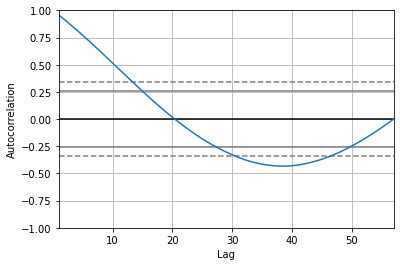

In [78]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(dataset['Cases'])
plt.show()

### ARIMA (the time series data must be stationary) 

#### ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:
1. Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
2. Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
3. Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results. An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. Lets discuss them first.
1. Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
2.	Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.



/Users/daniela/.local/share/virtualenvs/project3-n0KAOclj/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


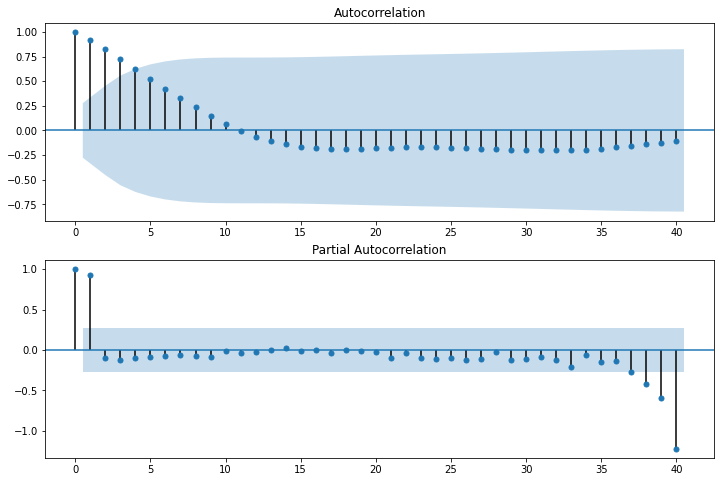

In [52]:
#ACF and PACF plots:

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm


fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dataset['NewCases_14'].iloc[7:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dataset['NewCases_14'].iloc[7:],lags=40,ax=ax2)


#### 

In [53]:
# For non-seasonal data
#p=4, d=1, q=0 or 1
from statsmodels.tsa.arima_model import ARIMA

model=ARIMA(dataset['Cases'],order=(4,1,1))
model_fit=model.fit()

/Users/daniela/.local/share/virtualenvs/project3-n0KAOclj/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/daniela/.local/share/virtualenvs/project3-n0KAOclj/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [54]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Cases   No. Observations:                   56
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -526.939
Method:                       css-mle   S.D. of innovations           2874.546
Date:                Mon, 11 May 2020   AIC                           1067.878
Time:                        05:55:49   BIC                           1082.056
Sample:                    03-16-2020   HQIC                          1073.375
                         - 05-10-2020                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.661e+04   9148.683      1.815      0.069   -1321.925    3.45e+04
ar.L1.D.Cases     1.3197      0.265      4.986      0.000       0.801       1.838
ar.L2.D.Cases    -0.3407      0.337     -1.011      0.312      -1.001       0.320
ar.L3.D.Cases    -0.2868      0.226     -1.269      0.204      -0.730       0.156
ar.L4.D.Cases     0.2867      0.133      2.158      0.031       0.026       0.547
ma.L1.D.Cases    -0.2390      0.251     -0.952      0.341      -0.731       0.253
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.7698           -0.0000j            1.7698           -0.5000
AR.2            1.0225           -0.0000j            1.0225           -0.0000
AR.3            0.8737           -1.0788j            1.3882           -0.1417
AR.4            0.8737           +1.0788j            1.3882            0.1417
MA.1            4.1848           +0.0000j            4.1848            0.0000
-----------------------------------------------------------------------------
"""

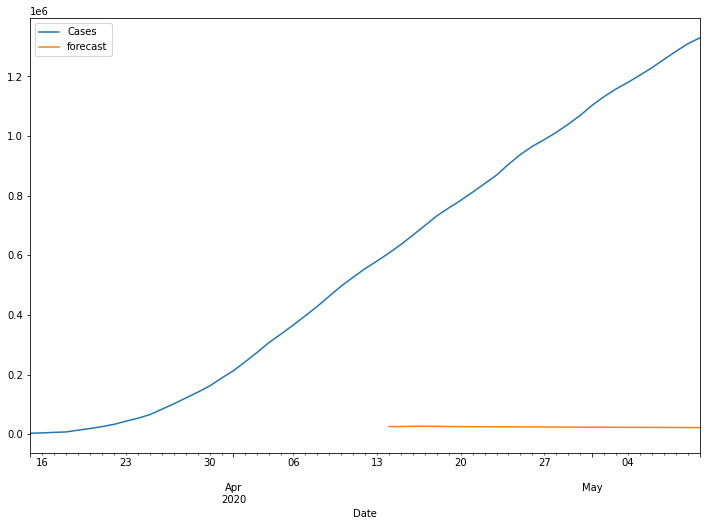

In [55]:
dataset['forecast']=model_fit.predict(start=30,end=110,dynamic=True)
dataset[['Cases','forecast']].plot(figsize=(12,8))

In [81]:
import statsmodels.api as sm

model=sm.tsa.statespace.SARIMAX(dataset['Cases'],order=(1, 1, 1),seasonal_order=(1,1,1,14))
results=model.fit()

/Users/daniela/.local/share/virtualenvs/project3-n0KAOclj/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/daniela/.local/share/virtualenvs/project3-n0KAOclj/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/daniela/.local/share/virtualenvs/project3-n0KAOclj/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


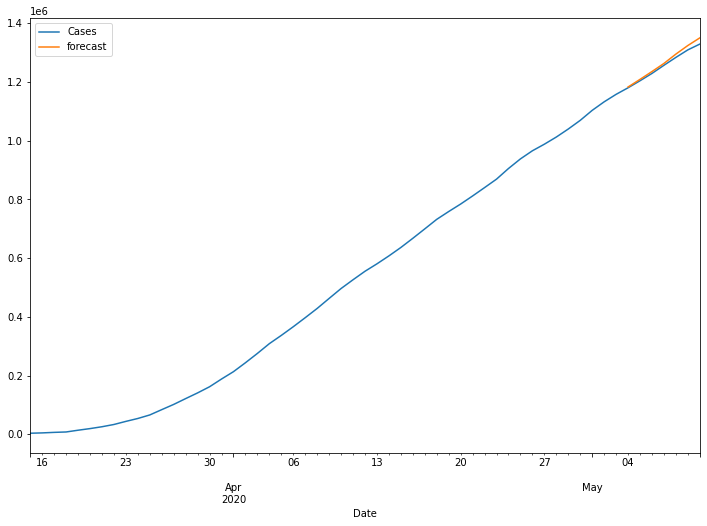

In [82]:
dataset['forecast']=results.predict(start=50,end=114,dynamic=True)
dataset[['Cases','forecast']].plot(figsize=(12,8))

In [83]:
from pandas.tseries.offsets import DateOffset
future_dates=[dataset.index[-1]+ DateOffset(days=x)for x in range(0,14)]

In [84]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=dataset.columns)
future_datest_df.tail()


,ISO3,Country,Cases,Deaths,Recovered,NewCases_1,NewCases_14,forecast
2020-05-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
future_df=pd.concat([dataset,future_datest_df])


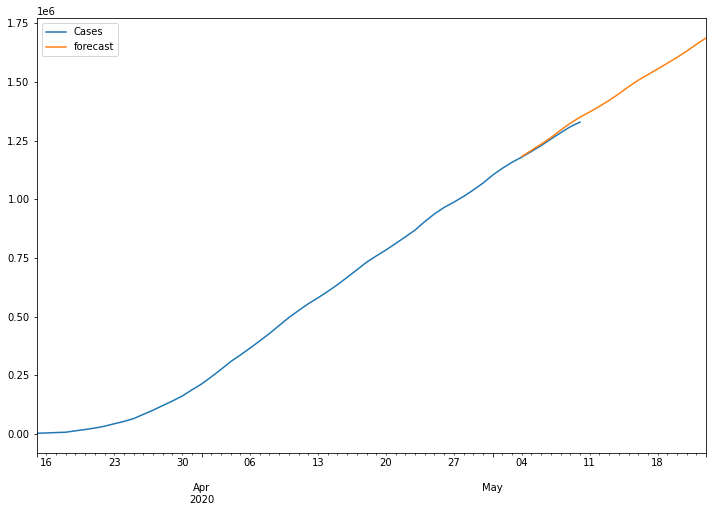

In [86]:
future_df['forecast'] = results.predict(start = 50, end = 114, dynamic= True)  
future_df[['Cases', 'forecast']].plot(figsize=(12, 8))

In [87]:
future_df

,ISO3,Country,Cases,Deaths,Recovered,NewCases_1,NewCases_14,forecast
2020-03-15,USA,US,3499,73,12,nan,nan,nan
2020-03-16,USA,US,4632,99,17,1133.000,nan,nan
2020-03-17,USA,US,6421,133,17,1789.000,nan,nan
2020-03-18,USA,US,7783,164,105,1362.000,nan,nan
2020-03-19,USA,US,13747,258,121,5964.000,nan,nan
...,...,...,...,...,...,...,...,...
2020-05-19,NaN,NaN,NaN,NaN,NaN,nan,nan,1580301.930
2020-05-20,NaN,NaN,NaN,NaN,NaN,nan,nan,1605412.612
2020-05-21,NaN,NaN,NaN,NaN,NaN,nan,nan,1631708.028
2020-05-22,NaN,NaN,NaN,NaN,NaN,nan,nan,1661094.182


In [88]:
future_df[future_df['forecast'].notnull() & (future_df['Cases'].isnull())]


,ISO3,Country,Cases,Deaths,Recovered,NewCases_1,NewCases_14,forecast
2020-05-11,NaN,NaN,NaN,NaN,NaN,nan,nan,1372559.036
2020-05-12,NaN,NaN,NaN,NaN,NaN,nan,nan,1396464.034
2020-05-13,NaN,NaN,NaN,NaN,NaN,nan,nan,1421928.077
2020-05-14,NaN,NaN,NaN,NaN,NaN,nan,nan,1449687.217
2020-05-15,NaN,NaN,NaN,NaN,NaN,nan,nan,1480144.365
2020-05-16,NaN,NaN,NaN,NaN,NaN,nan,nan,1507628.735
2020-05-17,NaN,NaN,NaN,NaN,NaN,nan,nan,1531774.603
2020-05-18,NaN,NaN,NaN,NaN,NaN,nan,nan,1555703.906
2020-05-19,NaN,NaN,NaN,NaN,NaN,nan,nan,1580301.930
2020-05-20,NaN,NaN,NaN,NaN,NaN,nan,nan,1605412.612


In [89]:
print((future_df['forecast'][55:]))


2020-05-09   1324412.017
2020-05-10   1350388.499
2020-05-11   1372559.036
2020-05-12   1396464.034
2020-05-13   1421928.077
2020-05-14   1449687.217
2020-05-15   1480144.365
2020-05-16   1507628.735
2020-05-17   1531774.603
2020-05-18   1555703.906
2020-05-19   1580301.930
2020-05-20   1605412.612
2020-05-21   1631708.028
2020-05-22   1661094.182
2020-05-23   1688206.953
Name: forecast, dtype: float64
